Instalar Librerias

In [1]:
pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 45.5 MB/s eta 0:00:00


In [3]:
pip install pulp pandas matplotlib


Horarios Planificados - semana_1:
             lunes         martes      miércoles         jueves  \
M1   turno_jornada  turno_jornada          Libre          Libre   
M2        turno_22  turno_jornada          Libre  turno_jornada   
M3           Libre       turno_22          Libre  turno_jornada   
M4   turno_jornada       turno_22          Libre          Libre   
M5           Libre       turno_22          Libre  turno_jornada   
M6           Libre  turno_jornada       turno_22  turno_jornada   
M7           Libre          Libre  turno_jornada          Libre   
M8           Libre          Libre          Libre  turno_jornada   
M9           Libre       turno_22          Libre  turno_jornada   
M10          Libre  turno_jornada          Libre          Libre   
M11          Libre          Libre  turno_jornada          Libre   
M12  turno_jornada          Libre  turno_jornada          Libre   

           viernes    sábado        domingo  
M1        turno_22     Libre          Libre  
M

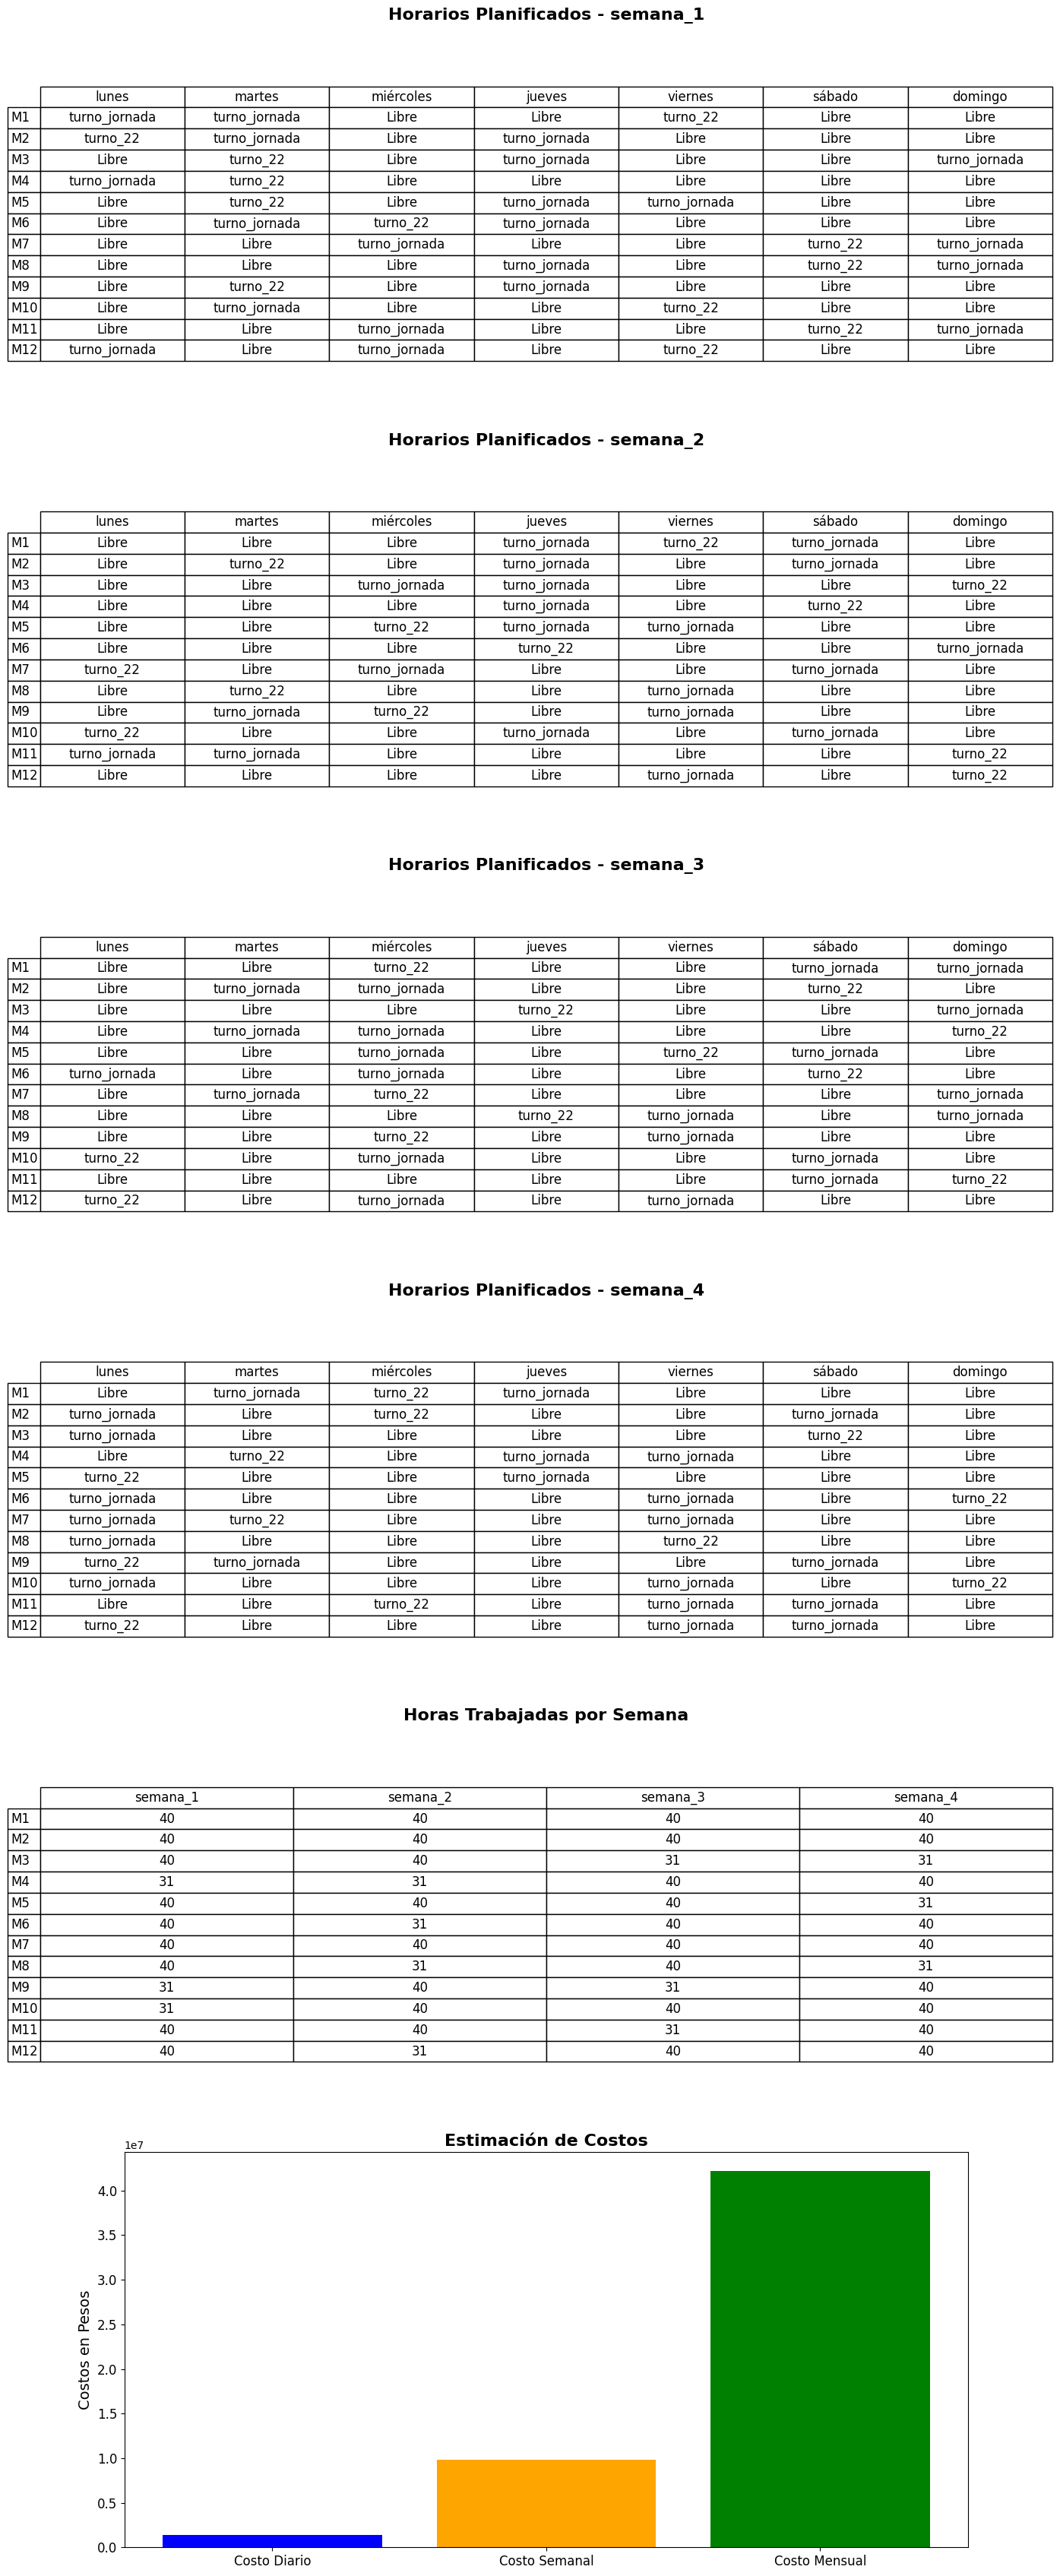

In [39]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt

# Parámetros
num_medicos = 12
horas_min = 40
horas_max = 52
costo_hora = 21986

# Tipos de turnos
turnos = {
    "turno_22": 22,
    "turno_22_28": 25,  # promedio de 22 a 28 horas
    "turno_jornada": 9  # 8am a 5pm, 9 horas
}

# Días de la semana
dias_semana = ["lunes", "martes", "miércoles", "jueves", "viernes", "sábado", "domingo"]
semanas = ["semana_1", "semana_2", "semana_3", "semana_4"]



# Crear el problema de optimización
prob = pulp.LpProblem("Turnos_Medicos", pulp.LpMinimize)

# Variables de decisión
turnos_vars = pulp.LpVariable.dicts("Turno", (dias_semana, semanas, range(num_medicos), turnos.keys()), 0, 1, pulp.LpBinary)

# Función objetivo: Minimizar el costo total
prob += pulp.lpSum([turnos_vars[d][w][m][t] * turnos[t] * costo_hora for d in dias_semana for w in semanas for m in range(num_medicos) for t in turnos.keys()])

# Restricciones de cobertura
for d in dias_semana:
    for w in semanas:
        if d in ["lunes", "martes", "miércoles", "jueves", "viernes"]:
            prob += pulp.lpSum([turnos_vars[d][w][m][t] for m in range(num_medicos) for t in turnos.keys()]) >= 3
        else:
            prob += pulp.lpSum([turnos_vars[d][w][m][t] for m in range(num_medicos) for t in turnos.keys()]) >= 2

# Restricciones de horas por médico
for m in range(num_medicos):
    for w in semanas:
        horas_semana = pulp.lpSum([turnos_vars[d][w][m][t] * turnos[t] for d in dias_semana for t in turnos.keys()])
        prob += horas_semana >= horas_min
        prob += horas_semana <= horas_max

# Modificar la restricción de fin de semana libre para mayor flexibilidad
# Se asegura que cada doctor tenga al menos 2 días libres por semana
for m in range(num_medicos):
    for w in semanas:
        prob += pulp.lpSum([turnos_vars[d][w][m][t] for d in dias_semana for t in turnos.keys()]) <= (7 - 2) * max(turnos.values())

# Resolver el problema
prob.solve()







# Crear los DataFrames de horarios para cada semana
horarios = {w: pd.DataFrame(index=["M" + str(i+1) for i in range(num_medicos)], columns=dias_semana) for w in semanas}
horas_trabajadas = pd.DataFrame(index=["M" + str(i+1) for i in range(num_medicos)], columns=semanas)

for w in semanas:
    for m in range(num_medicos):
        horas_totales_semana = 0
        for d in dias_semana:
            turno_asignado = [t for t in turnos.keys() if turnos_vars[d][w][m][t].varValue == 1]
            if turno_asignado:
                horarios[w].loc["M" + str(m+1), d] = turno_asignado[0]
                horas_totales_semana += turnos[turno_asignado[0]]
            else:
                horarios[w].loc["M" + str(m+1), d] = "Libre"
        horas_trabajadas.loc["M" + str(m+1), w] = horas_totales_semana

# Estimación de costos
costo_diario = pulp.value(prob.objective) / 30
costo_semanal = costo_diario * 7
costo_mensual = costo_diario * 30

costos_estimados = {
    "Costo Diario": costo_diario,
    "Costo Semanal": costo_semanal,
    "Costo Mensual": costo_mensual
}

# Resultados de horarios
for w in semanas:
    print(f"\nHorarios Planificados - {w}:")
    print(horarios[w])

print("\nEstimación de Costos:")
print(costos_estimados)

# Graficar horarios y costos

# Crear figura y ejes
fig, axs = plt.subplots(6, 1, figsize=(14, 34))

# Graficar las tablas de horarios
for i, w in enumerate(semanas):
    axs[i].axis('tight')
    axs[i].axis('off')
    table = axs[i].table(cellText=horarios[w].values, colLabels=horarios[w].columns, rowLabels=horarios[w].index, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    axs[i].set_title(f'Horarios Planificados - {w}', fontsize=16, fontweight='bold')

# Graficar la tabla de horas trabajadas
axs[4].axis('tight')
axs[4].axis('off')
table = axs[4].table(cellText=horas_trabajadas.values, colLabels=horas_trabajadas.columns, rowLabels=horas_trabajadas.index, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
axs[4].set_title('Horas Trabajadas por Semana', fontsize=16, fontweight='bold')

# Graficar los costos
axs[5].bar(costos_estimados.keys(), costos_estimados.values(), color=['blue', 'orange', 'green'])
axs[5].set_title('Estimación de Costos', fontsize=16, fontweight='bold')
axs[5].set_ylabel('Costos en Pesos', fontsize=14)
axs[5].set_xticks(range(len(costos_estimados.keys())))
axs[5].set_xticklabels(costos_estimados.keys(), fontsize=12)
axs[5].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()


Inicio del Algoritmo:

1. Definir las variables de decisión:
   - Para cada día de la semana, para cada semana, para cada médico y para cada tipo de turno:
     - Crear una variable binaria para representar si un médico está asignado a un turno específico.

2. Establecer la función objetivo:
   - Minimizar el costo total de los turnos asignados:
     - Sumar el producto de cada variable de decisión (representando la asignación de turnos)
       por el costo del turno y el costo por hora.

3. Aplicar restricciones de cobertura:
   - Para cada día de la semana y cada semana:
     - Si el día es de lunes a viernes:
       - Asegurar que al menos 3 médicos estén asignados a turnos.
     - Si es sábado o domingo:
       - Asegurar que al menos 2 médicos estén asignados a turnos.

4. Aplicar restricciones de horas por médico:
   - Para cada médico y cada semana:
     - Calcular las horas trabajadas por el médico sumando las horas de los turnos asignados.
     - Asegurar que las horas trabajadas estén entre el límite mínimo y máximo permitido.

Fin del Algoritmo